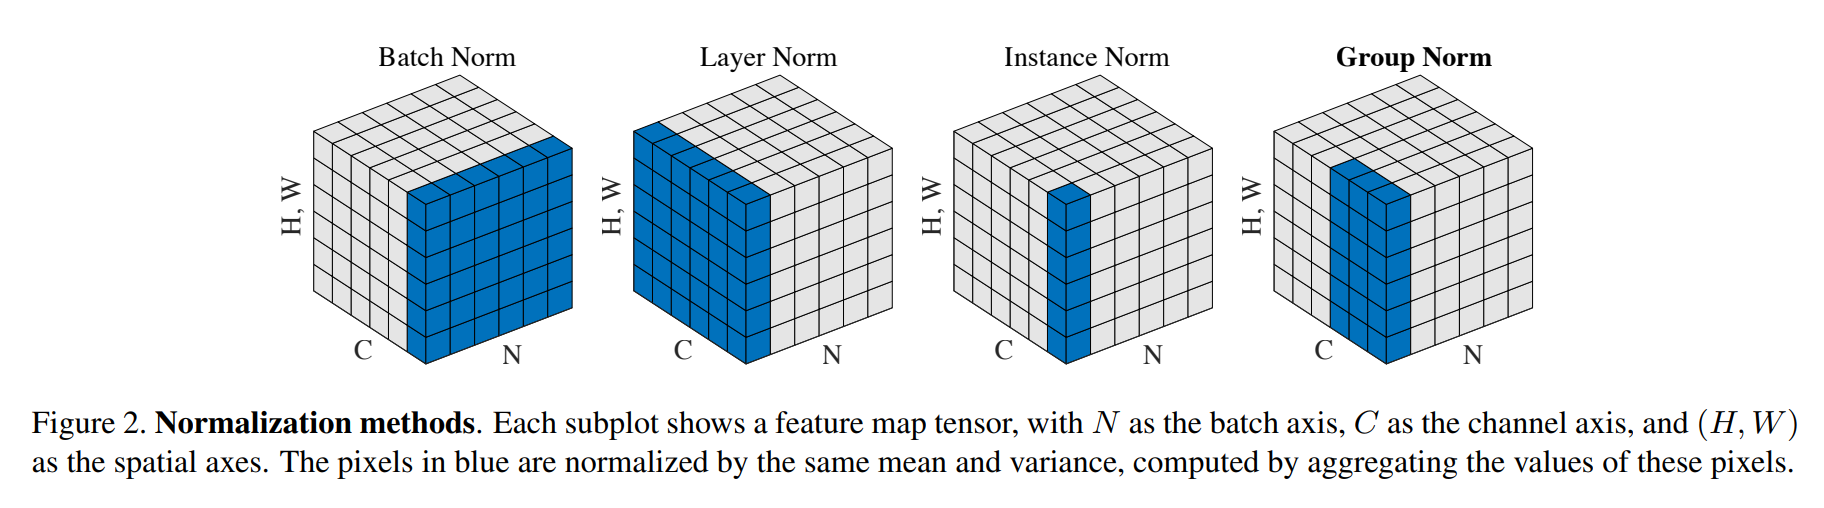

# https://arxiv.org/pdf/1607.06450

# https://arxiv.org/pdf/1502.03167

# https://arxiv.org/pdf/1803.08494

# https://arxiv.org/pdf/1607.08022


# Deep Learning Normalization Techniques — Comprehensive Comparison

## 1. Comparative Overview

| Aspect | Batch Normalization (BN) | Layer Normalization (LN) | Group Normalization (GN) |
|----------|--------------------------|---------------------------|----------------------------|
| **Original Authors** | Sergey Ioffe, Christian Szegedy (2015) | Jimmy Lei Ba, Jamie Ryan Kiros, Geoffrey Hinton (2016) | Yuxin Wu, Kaiming He (2018) |
| **Normalization Axis** | Across batch dimension (per channel) | Across feature dimension within one sample | Across groups of channels within one sample |
| **Statistics Computed Over** | Mini-batch samples | All features of a layer (single example) | Subsets of channels (G groups) per example |
| **Depends on Batch Size?** | Yes | No | No |
| **Stable with Small Batches?** | Often unstable | Yes | Yes |
| **Training vs Inference Behavior** | Different (uses running averages at inference) | Identical | Identical |
| **Uses Running Statistics?** | Yes | No | No |
| **Sensitivity to Batch Size** | High | None | None |
| **Internal Covariate Shift Reduction** | Explicitly proposed to reduce it | Does not rely on batch statistics | Not framed as ICS reduction |
| **Learning Rate Scaling** | Enables significantly higher LR | Moderately stabilizes | Stabilizes without LR dependence on batch |
| **Regularization Effect** | Implicit regularization from batch noise | Minimal implicit regularization | Minimal implicit regularization |
| **Works Well For** | Large-scale CNN image classification | RNNs, Transformers, sequence models | Vision tasks with small batches |
| **Not Ideal For** | Small-batch training, variable batch sizes | Very deep CNNs without tuning | Extremely small channel counts |
| **Computational Cost** | Slightly higher due to batch aggregation | Efficient | Efficient |
| **Memory Efficiency** | Good | Good | Good |
| **Parallelization Across Devices** | Requires sync (SyncBN) for multi-GPU | Naturally independent | Naturally independent |
| **Sensitivity to Distributed Training** | High (needs synchronized stats) | None | None |
| **Works with Variable Sequence Length?** | Difficult | Excellent | Good |
| **Typical Placement** | After Conv / Linear, before activation | Inside residual blocks, before activation | Inside residual Conv blocks |
| **Affine Parameters ($\gamma$, $\beta$)** | Yes | Yes | Yes |
| **Effect on Gradient Flow** | Smooths optimization landscape | Stabilizes hidden state dynamics | Stabilizes channel-wise feature scaling |
| **Effect on Feature Scaling** | Normalizes across samples | Normalizes across features | Normalizes structured channel subsets |
| **Interpretation** | Dataset-level normalization per step | Instance-level normalization | Structured instance normalization |
| **Relationship to InstanceNorm** | Different (uses batch stats) | Different | GN with $G=C$ equals InstanceNorm |
| **Relationship to LN** | Different axis | GN with $G=1$ equals LN | Interpolates between LN and InstanceNorm |
| **Best in CNNs?** | Yes (large batch) | Moderate | Yes (small batch) |
| **Best in Transformers?** | No | Yes (standard choice) | Rare |
| **Used in ResNet (original)?** | Yes | No | Modern variants |
| **Used in GPT/BERT?** | No | Yes | No |
| **Used in Diffusion U-Nets?** | Rare | Rare | Very common |
| **Why Used in Diffusion Models?** | Batch instability issue | Less aligned with Conv channel grouping | Stable with small batch, natural for Conv residual blocks |
| **Conditioning Compatibility (e.g., time embedding scaling)** | Possible but less standard | Possible | Very natural (scale/shift modulation after GN) |
| **Behavior Under Batch Size = 1** | Fails (degenerates) | Stable | Stable |
| **Stochasticity Source** | Mini-batch variance | None | None |
| **Impact on Generalization** | Often improves due to noise | Neutral | Neutral |
| **Mathematical Core** | $\mu_B, \sigma_B^2$ over batch | $\mu_L, \sigma_L^2$ over features | $\mu_G, \sigma_G^2$ over grouped channels |
| **Robustness to Dataset Distribution Shift** | Can be sensitive | More stable | More stable |
| **Primary Theoretical Motivation** | Reduce internal covariate shift | Stabilize hidden state transitions | Decouple normalization from batch size |
| **Primary Practical Advantage** | Fast convergence | Works with sequence models | Stable small-batch vision training |

---

## 2. Mathematical Formulation

### Batch Normalization

For a mini-batch of size $m$:

$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i
$$

$$
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
$$

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

$$
y_i = \gamma \hat{x}_i + \beta
$$

---

### Layer Normalization

For a single example with $d$ features:

$$
\mu_L = \frac{1}{d} \sum_{j=1}^{d} x_j
$$

$$
\sigma_L^2 = \frac{1}{d} \sum_{j=1}^{d} (x_j - \mu_L)^2
$$

$$
\hat{x}_j = \frac{x_j - \mu_L}{\sqrt{\sigma_L^2 + \epsilon}}
$$

$$
y_j = \gamma \hat{x}_j + \beta
$$

---

### Group Normalization

For each group containing $\frac{C}{G}$ channels:

$$
\mu_G = \frac{1}{|S_G|} \sum_{k \in S_G} x_k
$$

$$
\sigma_G^2 = \frac{1}{|S_G|} \sum_{k \in S_G} (x_k - \mu_G)^2
$$

$$
\hat{x}_k = \frac{x_k - \mu_G}{\sqrt{\sigma_G^2 + \epsilon}}
$$

$$
y_k = \gamma \hat{x}_k + \beta
$$

---

## 3. Key Conceptual Differences

### 3.1 Where the Statistics Come From

- **BN** → across examples  
- **LN** → across features  
- **GN** → across feature groups  

---

### 3.2 Batch Size Dependency Spectrum

$$
\text{BatchNorm} \quad \longrightarrow \quad \text{depends on batch}
$$

$$
\text{GroupNorm} \quad \longrightarrow \quad \text{independent}
$$

$$
\text{LayerNorm} \quad \longrightarrow \quad \text{independent}
$$

---

### 3.3 GroupNorm as a Continuum

| Group Count ($G$) | Equivalent To |
|-------------------|--------------|
| $G = 1$ | LayerNorm |
| $G = C$ | InstanceNorm |
| $1 < G < C$ | GroupNorm (intermediate behavior) |

Group Normalization forms a structural continuum between LayerNorm and InstanceNorm, making it particularly suitable for convolutional architectures.

---

## 4. Why Diffusion Models Prefer GroupNorm

Diffusion U-Nets typically:

- Use small per-GPU batch sizes  
- Are memory intensive (high-resolution images)  
- Use residual convolutional blocks  
- Inject conditioning (time embeddings) via scale/shift after normalization  

Group Normalization:

- Does not depend on batch statistics  
- Aligns naturally with convolutional channel grouping  
- Remains stable under batch size $=1$  
- Integrates cleanly with FiLM-style conditioning  

This makes GroupNorm the most practical normalization choice in diffusion architectures.


# Normalization Techniques — Concise Comparative Table

## Comparative Summary

| Aspect | Batch Norm (BN) | Layer Norm (LN) | Group Norm (GN) | Instance Norm (IN) |
|----------|----------------|----------------|----------------|----------------|
| **Core Definition** | Normalizes activations using mini-batch mean and variance per channel | Normalizes summed inputs using all units in a layer per sample | Normalizes features within channel groups per sample | Normalizes each channel independently per sample |
| **How It Works** | Compute $\mu_B, \sigma_B$ over batch → normalize → apply learnable $\gamma, \beta$ | Compute $\mu, \sigma$ over hidden units of a layer (single example) → apply $\gamma, \beta$ | Split $C$ channels into $G$ groups → compute $\mu, \sigma$ per group → apply $\gamma, \beta$ | Compute $\mu, \sigma$ per channel per image (spatial only) → apply $\gamma, \beta$ |
| **Normalization Axis** | $(N, H, W)$ per channel | $(C, H, W)$ per sample | $(C/G, H, W)$ per group per sample | $(H, W)$ per channel per sample |
| **Batch Dependency** | Yes | No | No | No |
| **Training vs Test** | Uses running averages at test | Same computation at train and test | Same computation at train and test | Applied at test time as well |
| **Primary Motivation** | Reduce internal covariate shift | Stabilize hidden state dynamics (especially in RNNs) | Remove batch-size limitation of BN | Remove instance-specific contrast for stylization |
| **Positive Effects** | Enables higher learning rates; faster convergence; acts as regularizer | Stable hidden dynamics; works for RNNs; no mini-batch constraint | Stable across small batches; transfers well to detection and segmentation | Improved stylization quality; removes contrast artifacts |
| **Main Use Cases (per paper)** | Image classification CNNs | RNNs, sequence models | Vision tasks with small batch (detection, segmentation, video) | Fast neural style transfer |
| **Key Limitation** | Performance degrades with small batch sizes | Less effective than BN for some CNN tasks | Requires choosing group number $G$ | Ignores channel dependency; tailored for generation |
| **Invariance Properties** | Invariant to weight rescaling; partially to data shifts | Invariant to weight matrix rescaling and shifting | Independent of batch size | Instance-wise contrast invariance |
| **Extremes Relationship** | — | Equivalent to GN when $G=1$ | $G=1$ → LN; $G=C$ → IN | Equivalent to GN when $G=C$ |

---

## Mathematical Formulations

### Batch Normalization

For mini-batch size $m$:

$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i
$$

$$
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2
$$

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

$$
y_i = \gamma \hat{x}_i + \beta
$$

---

### Layer Normalization

For feature dimension $d$ within one sample:

$$
\mu_L = \frac{1}{d} \sum_{j=1}^{d} x_j
$$

$$
\sigma_L^2 = \frac{1}{d} \sum_{j=1}^{d} (x_j - \mu_L)^2
$$

$$
\hat{x}_j = \frac{x_j - \mu_L}{\sqrt{\sigma_L^2 + \epsilon}}
$$

$$
y_j = \gamma \hat{x}_j + \beta
$$

---

### Group Normalization

For each group containing $\frac{C}{G}$ channels:

$$
\mu_G = \frac{1}{|S_G|} \sum_{k \in S_G} x_k
$$

$$
\sigma_G^2 = \frac{1}{|S_G|} \sum_{k \in S_G} (x_k - \mu_G)^2
$$

$$
\hat{x}_k = \frac{x_k - \mu_G}{\sqrt{\sigma_G^2 + \epsilon}}
$$

$$
y_k = \gamma \hat{x}_k + \beta
$$

---

### Instance Normalization

For each channel independently within one sample:

$$
\mu_{IN} = \frac{1}{HW} \sum_{h,w} x_{h,w}
$$

$$
\sigma_{IN}^2 = \frac{1}{HW} \sum_{h,w} (x_{h,w} - \mu_{IN})^2
$$

$$
\hat{x}_{h,w} = \frac{x_{h,w} - \mu_{IN}}{\sqrt{\sigma_{IN}^2 + \epsilon}}
$$

$$
y_{h,w} = \gamma \hat{x}_{h,w} + \beta
$$

---

## Conceptual Summary

### Batch Normalization

Stabilizes deep convolutional network training by normalizing batch statistics.  
Introduces stochastic regularization through mini-batch noise.  
Performance is sensitive to batch size.

### Layer Normalization

Removes batch dependence entirely.  
Particularly effective for sequential and recurrent models.  
Identical behavior during training and inference.

### Group Normalization

Generalizes Layer Normalization and Instance Normalization.  
Designed to eliminate the small-batch instability of Batch Normalization.  
Strong performance in detection, segmentation, and video tasks.

### Instance Normalization

Performs per-image contrast normalization.  
Improves stylization quality in generative models.  
Applied consistently during both training and inference.
